**Problem 3: Code for Variational Auto-Encoder Algorithm using convolutional neural network from encoder and  deconvolutional neural network for decoder**

---



Getting the MNIST dataset and Normalizing it

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, img_size,img_size,1])
x_test = np.reshape(x_test,[-1, img_size,img_size,1])
x_train= x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
img_shape = (28, 28, 1)
batch_size = 128


Creating the Encoder and Decoder

In [ ]:
latent_dim = 2 #Number of latent dimension parameter

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense 
encoder_inputs = Input(shape=img_shape, name='input_encoder')
x = Conv2D(32, 3, padding='same', activation='relu')(encoder_inputs)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same',activation='relu')(x)
before_flatten_shape= K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mean = Dense(latent_dim,name='z_mean')(x)
z_log_sigma = layers.Dense(latent_dim,name='z_log_sigma')(x)

# sample vector from the latent distribution
z = Lambda(latent_sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])

# decoder model statement
encoder = Model(encoder_inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

# decoder takes the latent distribution sample as input
decoder_inputs = Input(K.int_shape(z)[1:]) 

# Expand to 784 total pixels
x = Dense(np.prod(before_flatten_shape[1:]),activation='relu')(decoder_inputs)

# Reshape
x = Reshape(before_flatten_shape[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_inputs, x, name='decoder')
decoder.summary()
# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_encoder[0][0]              
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
____________________________________________________________________________________________

Constructing a custom layer to calculate the loss

In [ ]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        reconstruction_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return K.mean(reconstruction_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([encoder_inputs, z_decoded])

Train the VAE

In [ ]:
epochs = 50
vae = Model(encoder_inputs, y, name='VAE_CNN')
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 28, 28, 32)   320         input_encoder[0][0]              
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_37[0][0]                  
________________________________________________________________________________________________

Display the MNIST trained digits

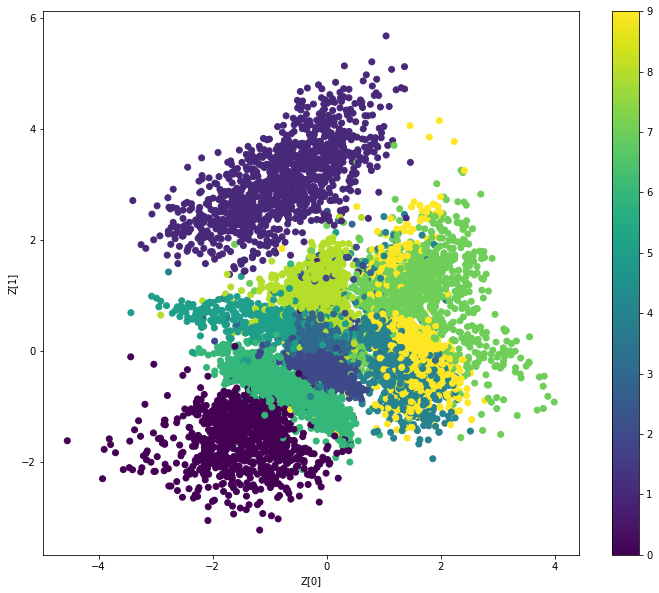

In [ ]:
# Clustering of digits in the latent space
def plot_results(encoder):
    z_test, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.savefig("VAE_CNN")
    plt.show()

plot_results(encoder);

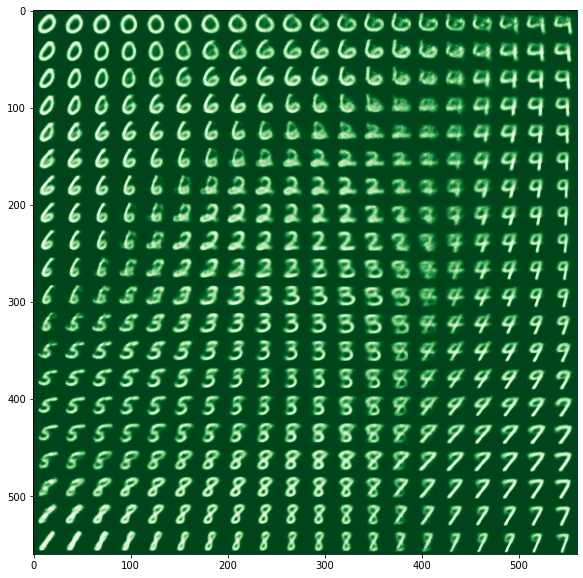

In [ ]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
dig_size = 28
figure= np.zeros((dig_size * n, dig_size * n))

# Construct grid of latent variable values
x_grid= norm.ppf(np.linspace(-3, 3, n))
y_grid = norm.ppf(np.linspace(-3, 3, n))

# decode for each square in the grid
for i, yi in enumerate(x_grid):
    for j, xi in enumerate(y_grid):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        dig = x_decoded[0].reshape(dig_size, dig_size)
        figure[i * dig_size: (i + 1) * dig_size,
               j * dig_size: (j + 1) * dig_size] = dig

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greens_r')
plt.show()